In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Test du calcul de la divergence sur une solution analytique
"""

DataFolder="C:/Users/Julie_000/Desktop/Stage/Stage_l3"
#DataFolder="E:/Clément/Julie/Stage_L3"

# Importations
## Modules

In [2]:
# Importation des librairies
import matplotlib.pyplot as plt # pour tracer les figures
import os # pour modifier le dossier de travail
import numpy as np # pour travailler avec des array
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)

import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver

import scipy as sc #pour l'analyse
from matplotlib.ticker import MaxNLocator #pour les courbes de niveau
from scipy.ndimage import gaussian_filter #Filtrage gaussien

import fonctions_projet_divergence as fpd

## colormap

In [3]:
colormap2=cm.RdBu#colormap

# Constitution des tableaux x et y

In [4]:
#Pour x
ligne_x=np.reshape(np.arange(-9.83,10.13,0.1),(1,200))#bidouillage pour que 0 ne soit pas dans le tableau
colonne_x=np.ones((200,1))

#ligne_y=np.ones((1,200))
#colonne_y=np.reshape(np.arange(-10.237,9.737,0.1),(200,1))

x=np.dot(colonne_x,ligne_x)
y=np.transpose(x)
#y=np.dot(colonne_y,ligne_y)


print(np.shape(x),x)
print(np.shape(y),y)
print(x.any()==0)

(200, 200) [[-9.83 -9.73 -9.63 ...  9.87  9.97 10.07]
 [-9.83 -9.73 -9.63 ...  9.87  9.97 10.07]
 [-9.83 -9.73 -9.63 ...  9.87  9.97 10.07]
 ...
 [-9.83 -9.73 -9.63 ...  9.87  9.97 10.07]
 [-9.83 -9.73 -9.63 ...  9.87  9.97 10.07]
 [-9.83 -9.73 -9.63 ...  9.87  9.97 10.07]]
(200, 200) [[-9.83 -9.83 -9.83 ... -9.83 -9.83 -9.83]
 [-9.73 -9.73 -9.73 ... -9.73 -9.73 -9.73]
 [-9.63 -9.63 -9.63 ... -9.63 -9.63 -9.63]
 ...
 [ 9.87  9.87  9.87 ...  9.87  9.87  9.87]
 [ 9.97  9.97  9.97 ...  9.97  9.97  9.97]
 [10.07 10.07 10.07 ... 10.07 10.07 10.07]]
False


# Solution analytique : disque bougeant à la surface d'un liquide

Ces solutions analytiques concernent spécifiquement le cas d’un disque bougeant à la surface d’un liquide,
dans un repère cylindrique centré sur un nageur disque de rayon unité. On se place en z=0.

## Implémentation des fonctions
### Convertion coordonnées 
Les solutions sont données en coordonnées cylindrique, on se place en cartésien


In [5]:
#cartésien en cylindrique
def r_cartesien(x,y):
    "Donne r cylindrique pour x et y donnés"
    r=np.sqrt(x**2+y**2)
    not_1=np.where(r==1,5,r)
    not_0=np.where(not_1==0,18,not_1)
    return(not_0)

def theta_cartesien1(x,y):
    "Donne theta cylindrique pour x et y donnés (ne marche que parce que x.any()==0 False)"
    return(np.arctan(y/x)+np.pi/2-np.sign(x)*np.pi/2)


def theta_cartesien2(x,y):
    "Donne theta cylindrique pour x et y donnés (ne marche que parce que x.any()==0 False)"
    return(np.where(x>0,np.arctan(y/x),np.arctan(y/x)+np.pi))

#cylindrique en cartésien
def x_y(r,theta):
    return(r*np.cos(theta),r*np.sin(theta))

def vitesse_en_cartesien(v_r,v_theta):
    "retourne les coordonnées cartésiennes de la vitesse à partir des cylindriques"
    v_x=v_r*np.cos(theta)-v_theta*np.sin(theta)
    v_y=v_r*np.sin(theta)+v_theta*np.cos(theta)
    return(v_x,v_y)


### Solutions analytiques

Ce sont les solutions pour u/U (normalisées)

In [6]:
def u_r(r,theta):
    "Retourne la coordonnée suivant e_r de la solution analytique"
    return(Xi*np.cos(theta)*(np.sqrt(r**2-1)/r**2+3*np.arcsin(1/r)))

def u_theta(r,theta):
    "Retourne la coordonnée suivant e_theta de la solution analytique"
    return(Xi*np.sin(theta)*(np.sqrt(r**2-1)/r**2-3*np.arcsin(1/r)))

def divergence_analytique(r,theta):
    return(Xi*np.cos(theta)*(-3*np.sqrt(1-1/r**2)/(r**2-1)+1/(r*np.sqrt(r**2-1))))


In [7]:
#fixation de Xi
Xi=2/(3*np.pi)

### Petits tests 
Je vérifie que pour un couple (x,y) donnant (r,theta) je retrouve (x,y) en applicant la transformation inverse. 
#### Définition des fonctions

In [8]:
def test(x,y,retour):
    "test pour voir si (r,theta) redonne bien (x,y)"
    r=r_cartesien(x,y)
    theta = theta_cartesien1(x,y)
    x_transform,y_transform = x_y(r,theta)
    x_bool,y_bool=np.isclose(x,x_transform),np.isclose(y,y_transform)
    if retour=="détails":
        return(x_bool,y_bool)
    else :
        return(x_bool.any()==False,y_bool.any()==False)
    

#### Test

In [9]:
print(test(x,y,"retour"))

(False, False)


Donc la transformation est correcte

## Tracé du champ de vitesse
### Fonction de plot

In [10]:
def plot_champ_vitesse(u,v,x,y,title):
    #bidouillage norme
    velocity=np.sqrt(u**2+v**2)
    colors = velocity
    #velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    #colors[velocity>velmax]=velmax
    norm = Normalize()
    norm.autoscale(colors)
    
    #nombre de flèches
    x=x[::4,::4]
    y=y[::4,::4]
    velocity=velocity[::4,::4]
    u=u[::4,::4]
    v=v[::4,::4]
    

    #plot   
    fig,ax=plt.subplots(num=title)
    im=ax.quiver(x,y,u/velocity,v/velocity,colors[::4,::4])
    fig.colorbar(im, ax=ax)  #pour la barre de couleur
    
    fig.suptitle(title,fontsize=16)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

### Naïvement
#### Constitution des tableaux

In [11]:
#theta et r
theta=theta_cartesien1(x,y)
r= r_cartesien(x,y)

#vitesses cylindriques
v_r=u_r(r,theta)
v_theta=u_theta(r,theta)

#vitesses en cartésien
v_x,v_y=vitesse_en_cartesien(v_r,v_theta)


C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arcsin
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


#### Plot

<IPython.core.display.Javascript object>


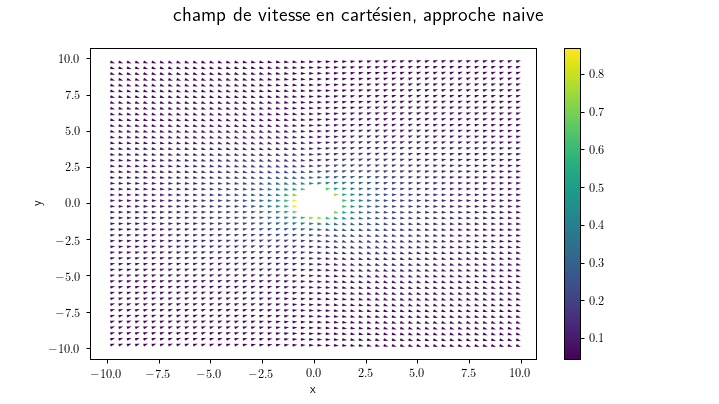

In [27]:
%matplotlib notebook
plot_champ_vitesse(v_x,v_y,x,y, "champ de vitesse en cartésien, approche naive")

Le programme rencontre des valeurs interdites mais cela semble marcher quand même et juste ne rien afficher là où il y a des problèmes.

### En excluant r<1
#### Définition des fonctions

In [13]:
def u_r_sup1(r,theta):
    "Retourne la coordonnée suivant e_r de la solution analytique pour r>1"
    inv=np.where(1/r>1,0,1/r) #problème avec le arcsin
    r=np.where(r>1,r,np.mean(r)) #problème avec la racine carrée
    fmorceau=np.sqrt(r**2-1)/r**2+3*np.arcsin(inv)
    return(np.where(r>1,Xi*np.cos(theta)*fmorceau,0)) #Je met 0 parce que je ne sais pas quoi mettre d'autre

def u_theta_sup1(r,theta):
    "Retourne la coordonnée suivant e_theta de la solution analytique pour r>1"
    inv=np.where(1/r>1,0,1/r) #problème avec le arcsin
    r=np.where(r>1,r,np.mean(r)) #problème avec la racine carrée
    fmorceau=np.sqrt(r**2-1)/r**2-3*np.arcsin(inv)
    return(np.where(r>1,Xi*np.sin(theta)*fmorceau,0)) #idem

#### Constitution des tableaux

In [14]:
#vitesses cylindriques
v_r_sup1=u_r_sup1(r,theta)
v_theta_sup1=u_theta_sup1(r,theta)

#vitesses en cartésien
v_x_sup1,v_y_sup1=vitesse_en_cartesien(v_r_sup1,v_theta_sup1)

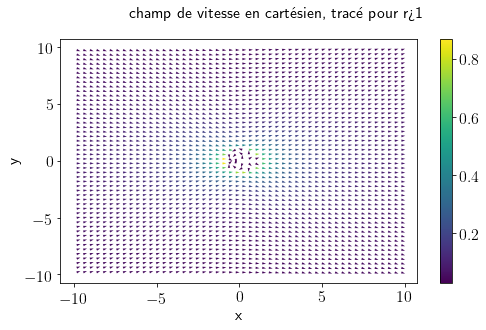

In [15]:
%matplotlib notebook
plot_champ_vitesse(v_x_sup1,v_y_sup1,x,y, "champ de vitesse en cartésien, tracé pour r>1")

## Tracé de la divergence analytique avec la formule
### Fonction de plot

In [16]:
def plot_divergence(div,title):
    "Fonction pour plot la divergence"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    #levels = MaxNLocator(nbins=5).tick_values(vmin, vmax)
    
    fig, l0 = plt.subplots(nrows=1,ncols=1,num=title)
    im0=l0.pcolormesh(x,y,div,cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    #im1 = l1.contourf(x,y,div,levels=levels, cmap=colormap2)
    #l1.set_title("Avec courbe de niveau")
    #fig.colorbar(im1,ax=l1)
    
    fig.tight_layout(pad=2.5)
    fig.suptitle(title,fontsize=20)
    plt.show()

### Chargement des tableaux

In [17]:
def divergence_analytique2(r,theta):
    "Ne fonctionne pas"
    r=np.where(r==1,r,np.mean(r))
    return(np.where(r>1,Xi*np.cos(theta)*(-3*np.sqrt(1-1/r**2)/(r**2-1)+1/(r*np.sqrt(r**2-1))),0))


div_analytique=divergence_analytique(r,theta)


C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


### Plot

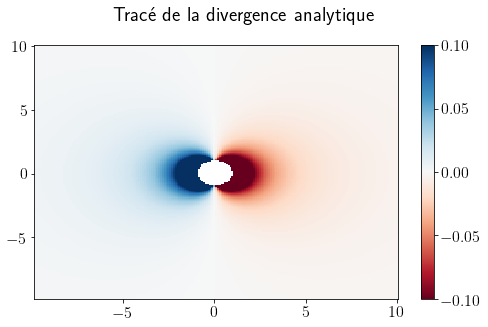

In [18]:
%matplotlib notebook
plot_divergence(div_analytique,"Tracé de la divergence analytique")

# Test du programme

On travaille ici avec les données v_r et v_theta analytiques, auxquelles on va ensuite appliquer le programme utilisé dans Projet_Divergence pour calculer la divergence.

## Application du programme sans filtrage
### Constitution des tableaux

In [19]:
"Dérivation"
du,dv=fpd.deriv(v_x,x,1),fpd.deriv(v_y,y,0)
dx,dy=fpd.abcisse(x,1),fpd.abcisse(y,0)

"Remise à la bonne taille"
du,dv=fpd.good_shape(du),fpd.good_shape(dv)
dx,dy=fpd.good_shape(dx),fpd.good_shape(dy)

"somme des tableaux"
div_numerique = fpd.somme(du,dv)
print(np.shape(dx))
print(np.max(div_analytique),np.min(div_analytique),np.mean(div_analytique),np.std(div_analytique))
vmin,vmax=np.max(div_analytique),np.min(div_analytique)

(199, 199)
nan nan nan nan


### Plot
#### Fonction de plot

In [20]:
def plot_divergence_num(div,title):
    "Fonction pour plot la divergence"
    #norme
    vmax,vmin=np.max(div),np.min(div)
    norm=Normalize(vmin=vmin, vmax=vmax)
    #levels = MaxNLocator(nbins=100).tick_values(div.min(), div.max())
    
    fig, l0 = plt.subplots(nrows=1,ncols=1,num=title)
    im0=l0.pcolormesh(dx,dy,div,cmap=colormap2,norm=norm)
    l0.set_title("Brut")
    fig.colorbar(im0,ax=l0)
    #im1 = l1.contourf(dx,dy,div,levels=levels, cmap=colormap2,norm=norm)
    #l1.set_title("Avec courbe de niveau")
    #fig.colorbar(im1,ax=l1)
    
    fig.tight_layout(pad=2.5)
    fig.suptitle(title,fontsize=20)
    plt.show()

#### plot

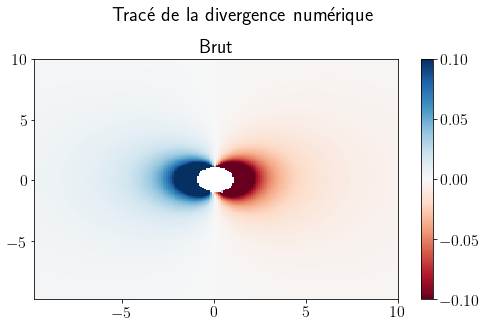

In [21]:
%matplotlib notebook
plot_divergence_num(div_numerique,"Tracé de la divergence numérique")

## Application du programme avec filtrage (sigma=1)
### Constitution des tableaux

In [22]:
#choix de sigma
sigma=0.5

#Tableaux
u_filtre=fpd.gaussian_filter(v_x,sigma)
v_filtre=fpd.gaussian_filter(v_y,sigma)

#dérivation
du_filtre,dv_filtre=fpd.deriv(u_filtre,x,1),fpd.deriv(v_filtre,y,0)
#shape
du_filtre,dv_filtre=fpd.good_shape(du_filtre),fpd.good_shape(dv_filtre)
#somme
div_numerique_filtre = fpd.somme(du_filtre,dv_filtre)
print(np.shape(div_numerique_filtre))
print(np.max(div_numerique),np.min(div_numerique),np.mean(div_numerique),np.std(div_numerique))
vmin,vmax=np.max(div_numerique),np.min(div_numerique)

(199, 199)
nan nan nan nan


# Comparaison des procédures
## Fonction de tracé

In [42]:
def plot_comparaison_divergence_contour(div0,div1,div2,title,m):
    "Fonction pour plot la comparaison, mettre div_analytique en premier"
    if m==3:
        #norme
        extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1),np.max(div2),np.min(div1)])
        vmax,vmin=np.max(extremums),np.min(extremums)
        norm=Normalize(vmin=vmin, vmax=vmax)
        levels = MaxNLocator(nbins=100).tick_values(vmin, vmax)

        #Figure
        fig, (l0,l1,l2) = plt.subplots(nrows=3,ncols=1,num=title,figsize=(7,9))
        im0 = l0.contourf(x,y,div0,levels=levels, cmap=colormap2,norm=norm)
        l0.set_title("Divergence analytique")
        fig.colorbar(im0,ax=l0)

        im1 = l1.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
        l1.set_title("Divergence numérique")
        fig.colorbar(im1,ax=l1)

        im2 = l2.contourf(dx,dy,div2,levels=levels, cmap=colormap2,norm=norm)
        l2.set_title("Divergence numérique filtrée")
        fig.colorbar(im2,ax=l2)
    
    if m==2:
        #norme
        extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1)])
        vmax,vmin=np.max(extremums),np.min(extremums)
        norm=Normalize(vmin=vmin, vmax=vmax)
        levels = MaxNLocator(nbins=100).tick_values(vmin, vmax)

        #Figure
        fig, (l0,l1) = plt.subplots(nrows=2,ncols=1,num=title,figsize=(7,9))
        im0 = l0.contourf(x,y,div0,levels=levels, cmap=colormap2,norm=norm)
        l0.set_title("Divergence analytique")
        fig.colorbar(im0,ax=l0)

        im1 = l1.contourf(dx,dy,div1,levels=levels, cmap=colormap2,norm=norm)
        l1.set_title("Divergence numérique")
        fig.colorbar(im1,ax=l1)
        
    fig.tight_layout()
    fig.suptitle(title,fontsize=16)
    plt.show()
    
def plot_comparaison_divergence_brut(div0,div1,div2,title,m):
    "Fonction pour plot la comparaison, mettre div_analytique en premier"
        #norme
        extremums=np.array([np.max(div0),np.min(div0),np.max(div1),np.min(div1)])
        vmax,vmin=np.max(extremums),np.min(extremums)
        norm=Normalize(vmin=vmin, vmax=vmax)

        #Figure
        fig, (l0,l1) = plt.subplots(nrows=2,ncols=1,num=title,figsize=(7,9))
        im0 = l0.pcolormesh(x,y,div0, cmap=colormap2,norm=norm)
        l0.set_title("Divergence analytique")
        fig.colorbar(im0,ax=l0)

        im1 = l1.pcolormesh(dx,dy,div1, cmap=colormap2,norm=norm)
        l1.set_title("Divergence numérique")
        fig.colorbar(im1,ax=l1)
        
    fig.tight_layout(pad=3)
    fig.suptitle(title,fontsize=20)
    plt.show()

<IPython.core.display.Javascript object>


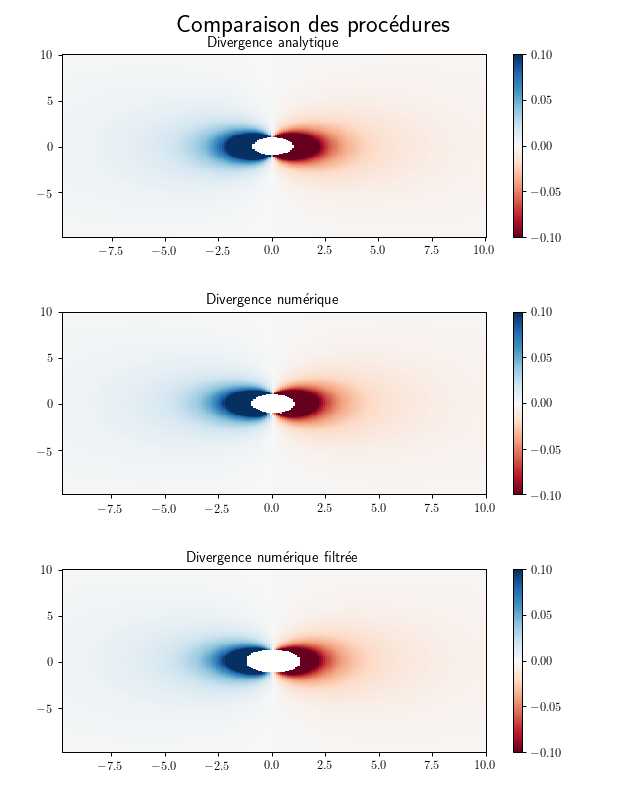

In [44]:
%matplotlib notebook
#nombre de plot (m=3 pour ajouter celui avec filtre, m=2 sinon)
m=3
plot_comparaison_divergence_brut(div_analytique,div_numerique,div_numerique_filtre,"Comparaison des procédures",m)

# Superposition de la carte de champ
## Définition de la fonction de plot

In [25]:
def plot_superposition (div,u,v,title):
    "Superposition des divergence et du champ de vitesse"
    n=np.shape(div)[0]
    #bidouillage norme
    velocity=np.sqrt(u**2+v**2)
    colors = velocity
    #velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
    #colors[velocity>velmax]=velmax
    norm = Normalize()
    norm.autoscale(colors)
    
    if n==199:
        x1=dx
        y1=dy
    elif n==200:
        x1=x
        y1=y
    else :
        return("le tableau n'a pas la bonne dimension")
    
    fig, l0 = plt.subplots(nrows=1,ncols=1,num=title)
    im0 = l0.pcolormesh(x1,y1,div, cmap=colormap2,norm=norm)
    fig.colorbar(im0,ax=l0)
    im1=l0.quiver(x[::4,::4],y[::4,::4],u[::4,::4]/velocity[::4,::4],v[::4,::4]/velocity[::4,::4],colors[::4,::4])
    fig.colorbar(im1, ax=l0)
        
    fig.tight_layout(pad=3.2)
    fig.suptitle(title,fontsize=20)
    plt.show()

## Plot

<IPython.core.display.Javascript object>


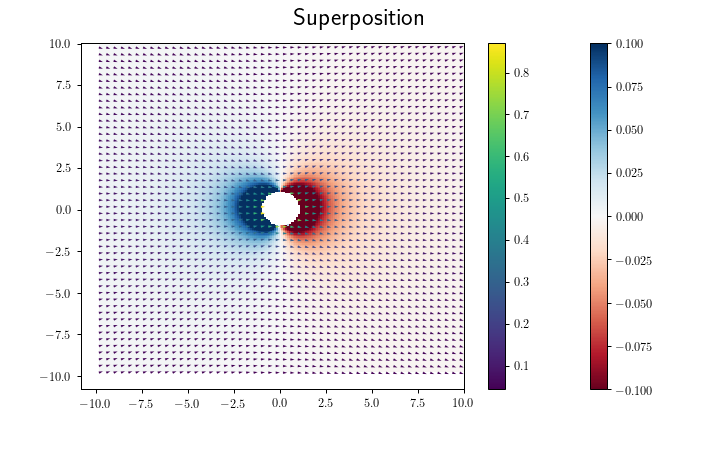

In [47]:
%matplotlib notebook
plot_superposition(div_numerique,v_x,v_y,"Superposition")